In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
import re
from tqdm import tqdm
from math import ceil
import os
from sklearn.metrics import mean_squared_error, classification_report
import joblib
from math import ceil
import warnings
from sklearn.model_selection import StratifiedKFold, cross_validate 
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
import logging
import random


SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
df = pd.read_csv('frames_errors.csv', header=None)
df.columns = [
    "block_id", "frame_idx", "E_mu_Z", "E_mu_phys_est", "E_mu_X", "E_nu1_X",
    "E_nu2_X", "E_nu1_Z", "E_nu2_Z", "N_mu_X", "M_mu_XX", "M_mu_XZ",
    "M_mu_X", "N_mu_Z", "M_mu_ZZ", "M_mu_Z", "N_nu1_X", "M_nu1_XX",
    "M_nu1_XZ", "M_nu1_X", "N_nu1_Z", "M_nu1_ZZ", "M_nu1_Z", "N_nu2_X",
    "M_nu2_XX", "M_nu2_XZ", "M_nu2_X", "N_nu2_Z", "M_nu2_ZZ", "M_nu2_Z",
    "nTot", "bayesImVoltage", "opticalPower", "polarizerVoltages_0_",
    "polarizerVoltages_1_", "polarizerVoltages_2_", "polarizerVoltages_3_",
    "temp_1", "biasVoltage_1", "temp_2", "biasVoltage_2", "synErr",
    "N_EC_rounds", "maintenance_flag", "estimator_name", "f_EC",
    "E_mu_Z_est", "R", "s", "p"
]

FEATURE_COLUMNS = [
    'E_mu_Z', 'E_mu_X', 'E_nu1_Z', 'E_nu2_Z',
    'temp_1', 'temp_2', 'opticalPower',
    'polarizerVoltages_0_', 'polarizerVoltages_1_',
    'polarizerVoltages_2_', 'polarizerVoltages_3_',
    'N_mu_Z', 'M_mu_Z', "R", "s", "f_EC"
]
TARGET_COLUMNS = ['E_mu_Z']

cols_to_process = list(dict.fromkeys(FEATURE_COLUMNS + TARGET_COLUMNS))
transformed_cols = df.groupby('block_id')[cols_to_process].transform(lambda x: x.interpolate(method='linear').ffill().bfill())
df.dropna(subset=cols_to_process, inplace=True)

#создаем новые фичи для лайтгбм(по f-строкам понятно что есть что)
def create_features(data, features, window_sizes=[4,20, 10], fill_method='ffill'):

    data = data.sort_values(['block_id', 'frame_idx']).reset_index(drop=True)
    df_features = data[['block_id','frame_idx']].copy()
    new_columns = []

    for col in features:
        for window in window_sizes:
            lag_col = data.groupby('block_id')[col].shift(window)
            lag_col.name = f'{col}_lag_{window}'
            new_columns.append(lag_col)

            roll_mean = data.groupby('block_id')[col].rolling(window=window).mean()
            roll_mean = roll_mean.reset_index(level=0, drop=True)
            roll_mean.name = f'{col}_roll_mean_{window}'
            new_columns.append(roll_mean)

            roll_std = data.groupby('block_id')[col].rolling(window=window).std()
            roll_std = roll_std.reset_index(level=0, drop=True)
            roll_std.name = f'{col}_roll_std_{window}'
            new_columns.append(roll_std)

    if new_columns:
        new_columns_df = pd.concat(new_columns, axis=1)
        df_features = pd.concat([df_features, new_columns_df], axis=1)


    if fill_method == 'ffill':
        df_features = df_features.fillna(method='ffill').fillna(method='bfill')
    elif fill_method == 'zero':
        df_features = df_features.fillna(0)
    elif fill_method == 'mean':
        df_features = df_features.fillna(df_features.mean())

    return df_features


X_features = create_features(df, FEATURE_COLUMNS, fill_method='ffill')
full_data = pd.merge(X_features, df[['block_id','frame_idx'] + TARGET_COLUMNS],
                     on=['block_id','frame_idx'], how='inner')

train_data = full_data.dropna().copy()
X_train = train_data.drop(columns=['block_id','frame_idx'] + TARGET_COLUMNS)
y_train = train_data[TARGET_COLUMNS]
# Находим правильные индексы для целевых фреймов
start_index = df[(df['block_id'] == 1489460492) & (df['frame_idx'] == 99)].index[0]
end_index = df[(df['block_id'] == 1840064900) & (df['frame_idx'] == 101)].index[0]

In [395]:
X_train = full_data.drop(columns=['block_id', 'frame_idx'] + TARGET_COLUMNS)
y_train = full_data[TARGET_COLUMNS]
tscv = TimeSeriesSplit(n_splits=5) 

meta_train = np.zeros(len(X_train))
meta_test_preds = []
fold_rmses = []

base_model_filename = 'lgbm_base_model_for_stacking.pkl'
print("   - Training base model...")
base_model_params = {
    'random_state': 42, 'n_estimators': 500, 
    'learning_rate': 0.05, 'num_leaves': 31,
    
}
base_model = lgb.LGBMRegressor(**base_model_params)
base_model.fit(X_train, y_train)
joblib.dump(base_model, base_model_filename)

for fold, (train_index, val_index) in enumerate(tscv.split(X_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    fold_model = lgb.LGBMRegressor(**base_model_params)
    fold_model.fit(X_train_fold, y_train_fold)
    val_preds = fold_model.predict(X_val_fold)
    meta_train[val_index] = val_preds

    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, val_preds))
    fold_rmses.append(fold_rmse)
    print(f"     Fold {fold+1} RMSE: {fold_rmse:.6f}")

mean_rmse = np.mean(fold_rmses)
std_rmse = np.std(fold_rmses)
print(f"\n   - Средний RMSE по {tscv.n_splits} фолдам: {mean_rmse:.6f} (±{std_rmse:.6f})")

print("   - Training meta-model...")
ridge_model_filename='ridge_ridge_model.pkl'
meta_X_train = np.column_stack([X_train, meta_train])
ridge_model = Ridge(random_state=42)
ridge_model.fit(meta_X_train, y_train)
joblib.dump(ridge_model, ridge_model_filename)

   - Training base model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32574
[LightGBM] [Info] Number of data points in the train set: 328486, number of used features: 142
[LightGBM] [Info] Start training from score 0.021919
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31665
[LightGBM] [Info] Number of data points in the train set: 54751, number of used features: 135
[LightGBM] [Info] Start training from score 0.022880
     Fold 1 RMSE: 0.001884
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

['ridge_ridge_model.pkl']

In [ ]:
TARGET_COLUMNS=['N_EC_rounds']

print("Подготовка данных для классификации N_EC_rounds...")


classification_data = pd.merge(X_features, 
                              df[['block_id', 'frame_idx', 'N_EC_rounds', 'R', 's']], 
                              on=['block_id', 'frame_idx'])

classification_data['target_ec'] = (classification_data['N_EC_rounds'] == 1).astype(int)

X_classif = classification_data.drop(columns=['block_id', 'frame_idx', 'N_EC_rounds', 'target_ec'])
y_classif = classification_data['target_ec']

print(f"Размерность данных для классификации: {X_classif.shape}")

Подготовка данных для классификации N_EC_rounds...
Размерность данных для классификации: (328486, 146)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier


feature_names = X_classif.columns.tolist()
log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
)


monotone_map = {'s': 1, 'R': -1} 
feature_names = X_classif.columns.tolist()
monotone_constraints = [monotone_map.get(f, 0) for f in feature_names]

lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    monotone_constraints=monotone_constraints,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)


'''
# --- 4. Кросс-валидация ---
cv = TimeSeriesSplit(n_splits=4)
scoring = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

cv_results = cross_validate(classifier, X_classif, y_classif, cv=cv, scoring=scoring, n_jobs=-1)

print("\n--- Средние метрики по 5 фолдам ---")
for metric in scoring:
    mean_val = np.mean(cv_results[f'test_{metric}'])
    std_val = np.std(cv_results[f'test_{metric}'])
    print(f"{metric.upper():<10}: {mean_val:.4f} (±{std_val:.4f})")
'''

log_reg.fit(X_classif, y_classif)
lgbm.fit(X_classif, y_classif)

[LightGBM] [Info] Number of positive: 107143, number of negative: 221343
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32838
[LightGBM] [Info] Number of data points in the train set: 328486, number of used features: 144
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [ ]:
def optimize_code_parameters_refined(
    e_mu_pred,
    current_features,
    classifier,
    feature_names,
    R_values=np.arange(0.5, 0.95, 0.05),
    sp_count=4800,
    prob_threshold=0.2,
):
    best_R, best_s = R_values[0], sp_count
    found_successful_code = False
    base_features = current_features.copy()

    coarse_R = sorted(R_values, reverse=True)
    coarse_s = np.arange(0, sp_count + 1, 600)

    test_cases = [(R, s) for R in coarse_R for s in coarse_s]

    batch_data = []
    for R, s in test_cases:
        fv = base_features.copy()
        fv["R"] = R
        fv["s"] = s
        batch_data.append(fv[feature_names].values)

    if not batch_data:
        return best_R, best_s, sp_count - best_s, False
        
    probs_lgbm = lgbm.predict_proba(batch_data)[:, 1]
    probs_logreg = log_reg.predict_proba(batch_data)[:, 1]
    probs = 0.2 * probs_lgbm + 0.8 * probs_logreg


    candidate_R, candidate_s, best_prob = None, None, -1
    for (R, s), prob in zip(test_cases, probs):
        adjusted_prob = prob + 0.001 * R 
        if adjusted_prob >= prob_threshold:
            if (candidate_R is None) or \
               (R > candidate_R) or \
               (R == candidate_R and (s < candidate_s or adjusted_prob > best_prob)):
                candidate_R, candidate_s, best_prob = R, s, adjusted_prob


    if candidate_R is not None:
        low, high = 0, sp_count
        best_s_success = sp_count

        for _ in range(12):
            mid_s = (low + high) // 2
            fv = base_features.copy()
            fv["R"], fv["s"] = candidate_R, mid_s
            prob = classifier.predict_proba([fv[feature_names].values])[0, 1]

            if prob >= prob_threshold:
                best_s_success = mid_s
                high = mid_s - 1
                found_successful_code = True
            else:
                low = mid_s + 1

        best_R = candidate_R
        best_s = max(0, min(sp_count, best_s_success))

    if not found_successful_code:
        idx = np.argmax(probs)
        best_R, best_s = test_cases[idx]
        max_prob = probs[idx]
        if max_prob < 0.5:
            best_R = max(0.5, best_R - 0.05)
            best_s = min(sp_count, best_s + 500)

    return best_R, best_s, sp_count - best_s, found_successful_code


target_indices = list(range(start_index, start_index + 2000))


common_indices = [idx for idx in target_indices if idx in X_features.index]

print(f"Найдено {len(common_indices)} общих индексов из 2000")


X_submission = X_features.loc[common_indices]


X_submission_clean = X_submission.drop(columns=['block_id', 'frame_idx'])


print("Предсказание E_mu_Z...")
base_preds = base_model.predict(X_submission_clean)
meta_X_submission = np.column_stack([X_submission_clean, base_preds])
final_predictions = ridge_model.predict(meta_X_submission)
final_predictions = final_predictions.flatten()

Найдено 2000 общих индексов из 2000
Предсказание E_mu_Z...


In [ ]:
print("Оптимизация параметров R, s, p...")
submission_rows = []
success_count = 0

for i, e_mu_pred in enumerate(tqdm(final_predictions, desc="Оптимизация параметров")):

    current_features = X_submission_clean.iloc[i]
    
    R_opt, s_opt, p_opt, success = optimize_code_parameters_refined(
        e_mu_pred, current_features, classifier, feature_names
    )
    
    if success:
        success_count += 1
    
    submission_rows.append([
        f"{e_mu_pred:.16f}",
        f"{R_opt:.2f}",
        f"{int(s_opt)}",
        f"{int(p_opt)}"
    ])


submission_df = pd.DataFrame(submission_rows[:2000])
submission_df.to_csv("submission.csv", header=False, index=False)
print(f"Создан submission.csv с {len(submission_df)} строками")

Оптимизация параметров R, s, p...


Оптимизация параметров: 100%|██████████████████████████████████████████████████████| 2000/2000 [04:23<00:00,  7.59it/s]

Успешно оптимизировано: 931/2000
Создан submission.csv с 2000 строками


In [449]:
import pandas as pd
df = pd.read_csv("submission.csv", header=None, names=['E_mu_Z','R','s','p'])
print(df['R'].value_counts(normalize=True))

R
0.65    0.3340
0.85    0.2930
0.60    0.1985
0.80    0.1225
0.90    0.0475
0.75    0.0025
0.55    0.0020
Name: proportion, dtype: float64


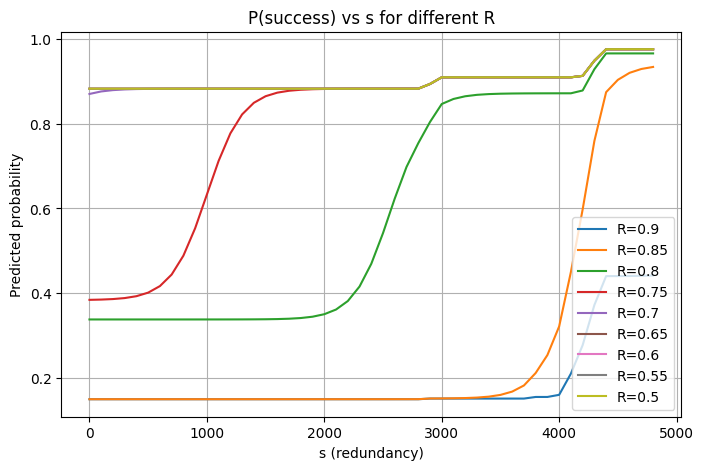

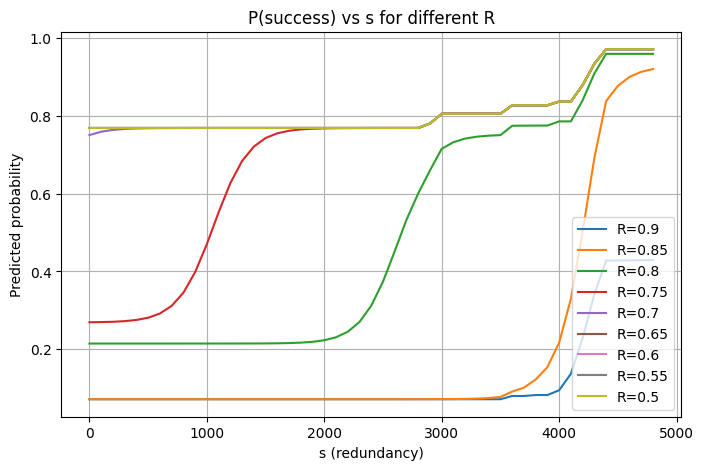

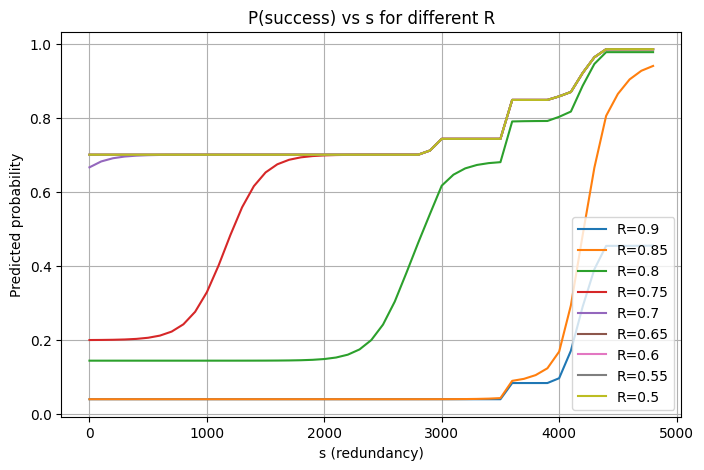

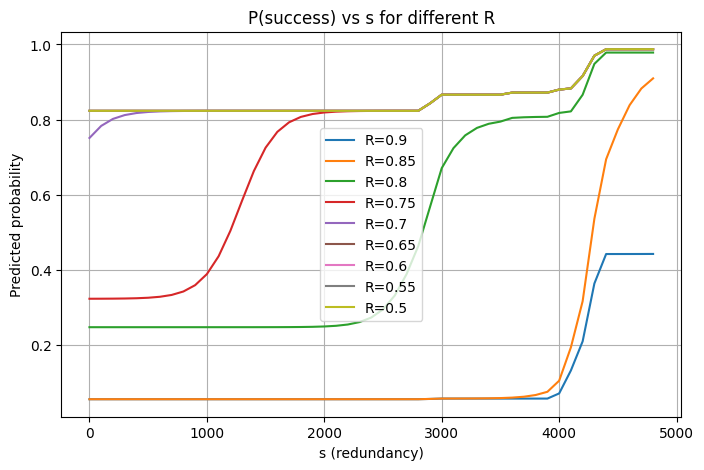

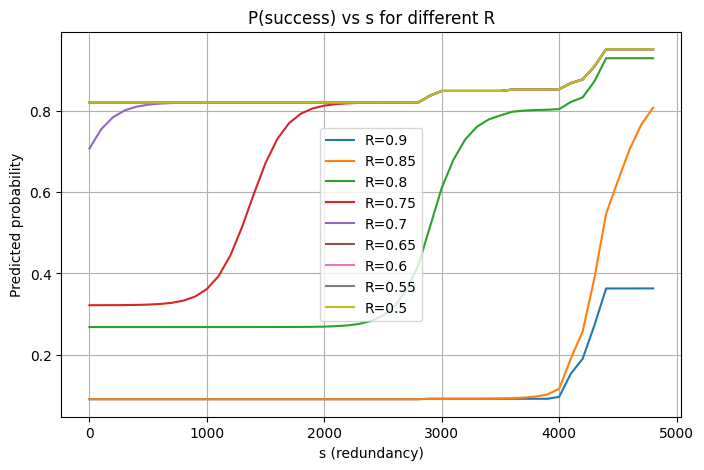

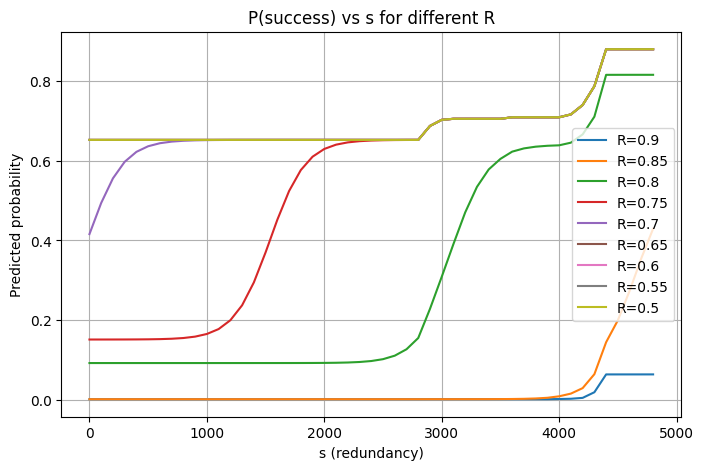

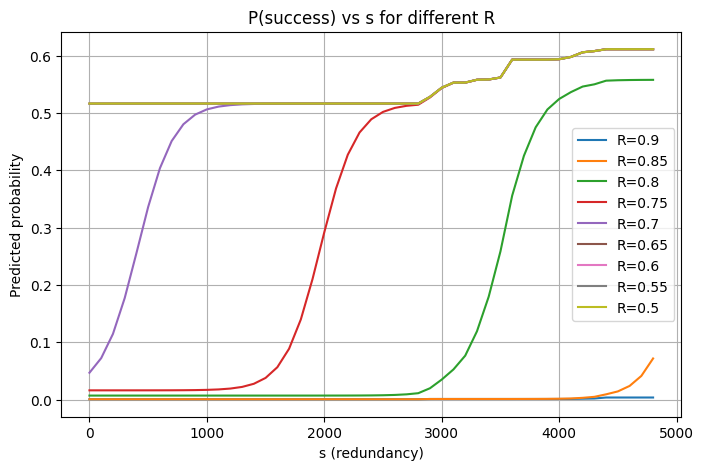

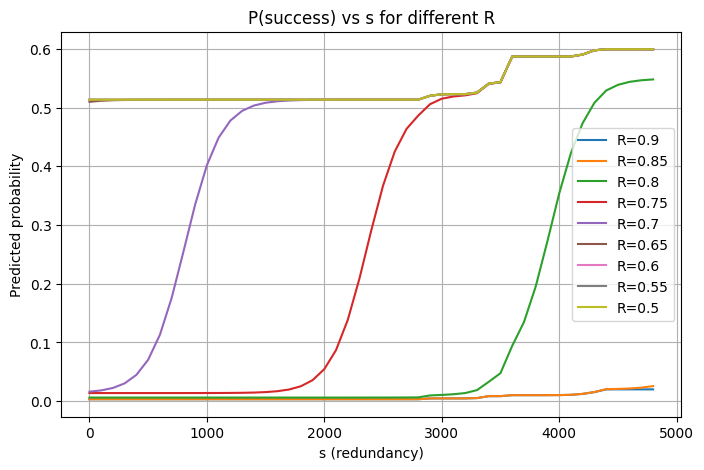

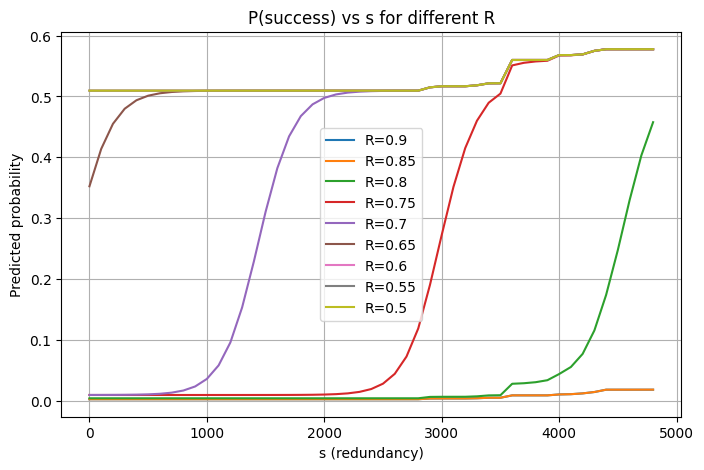

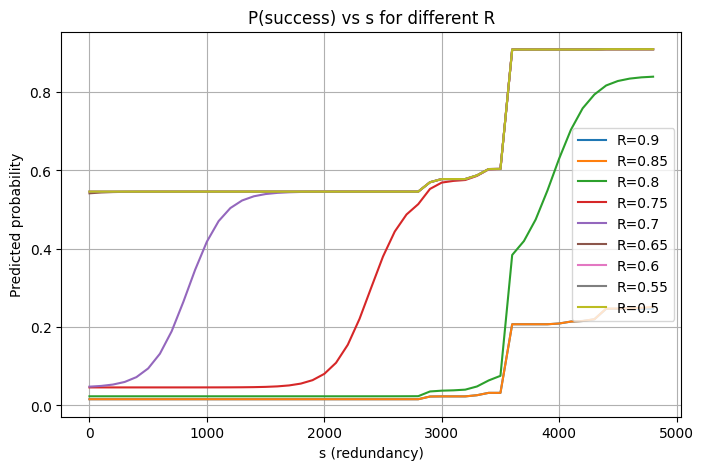

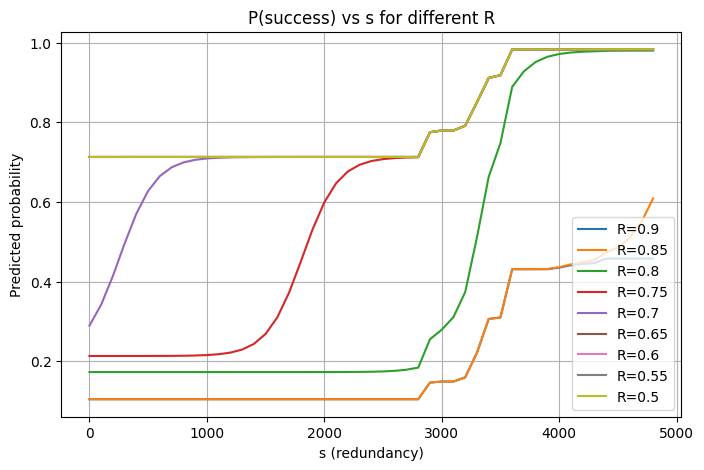

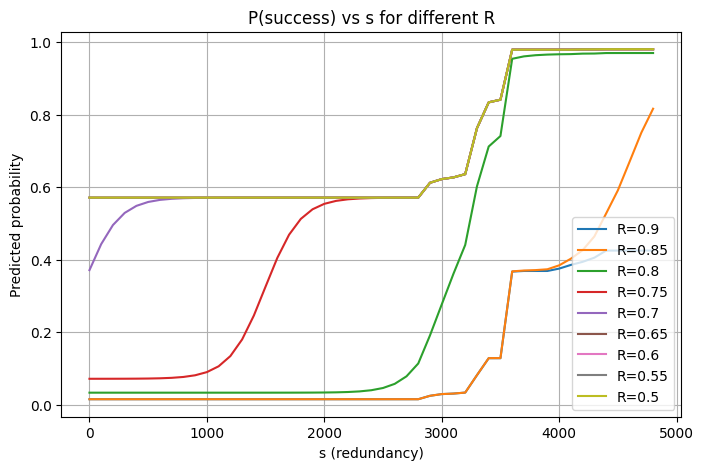

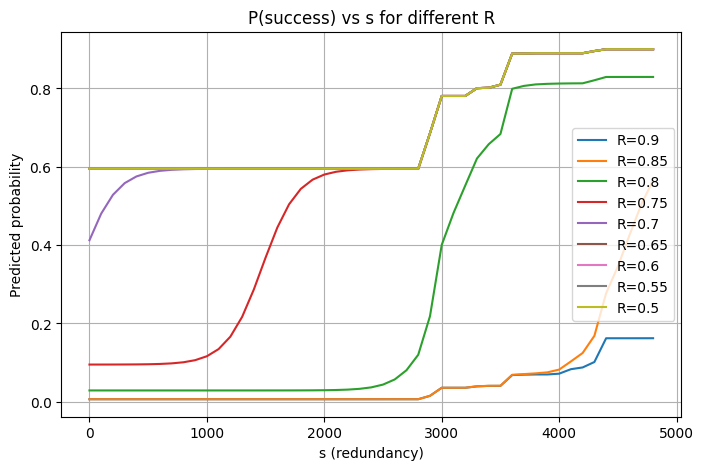

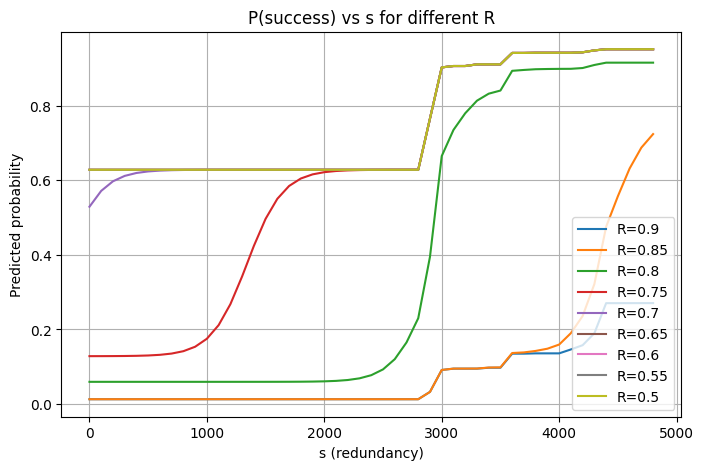

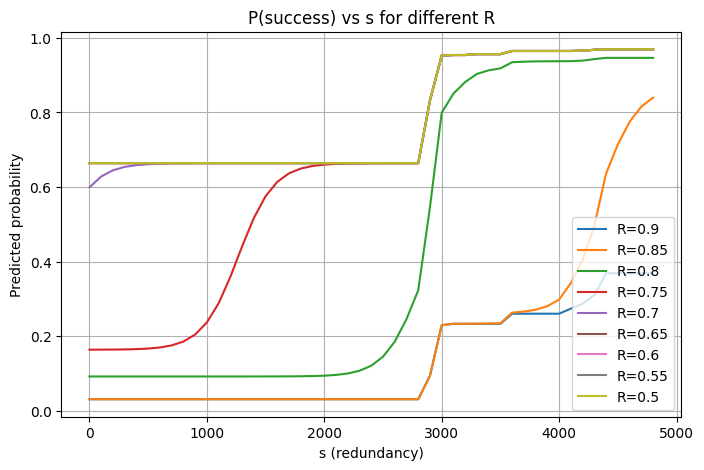

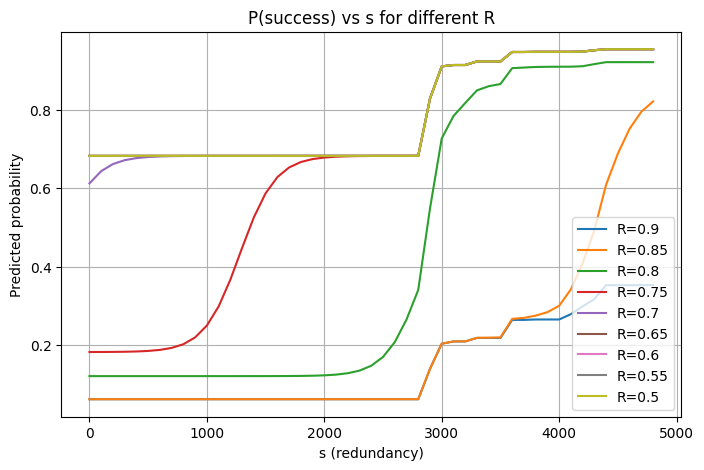

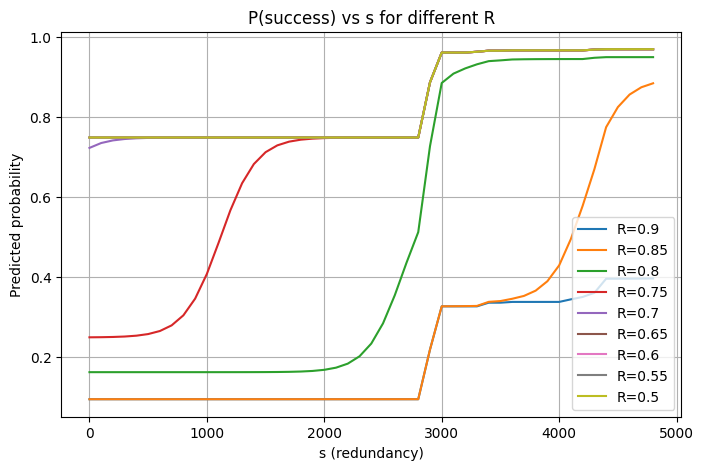

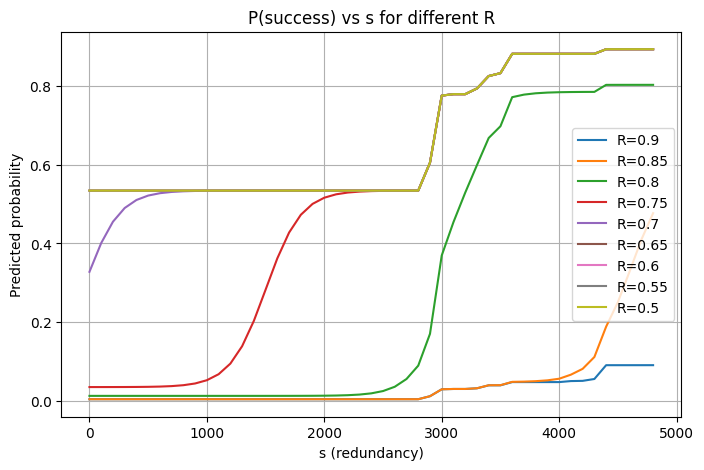

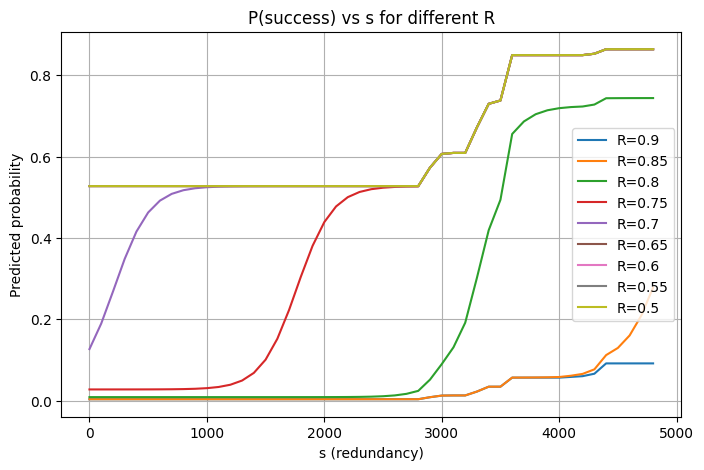

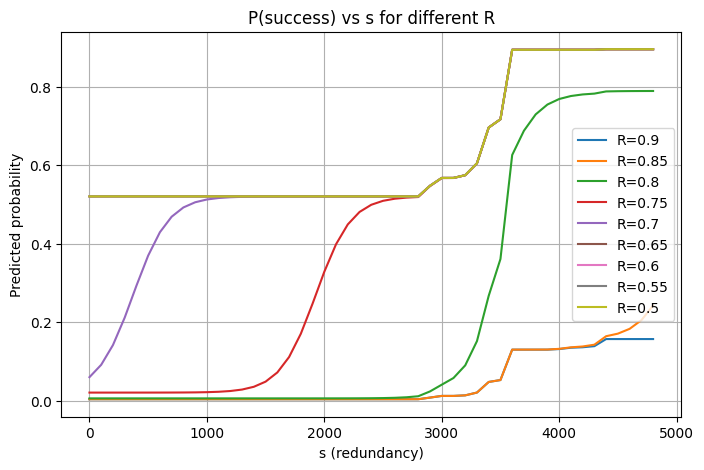

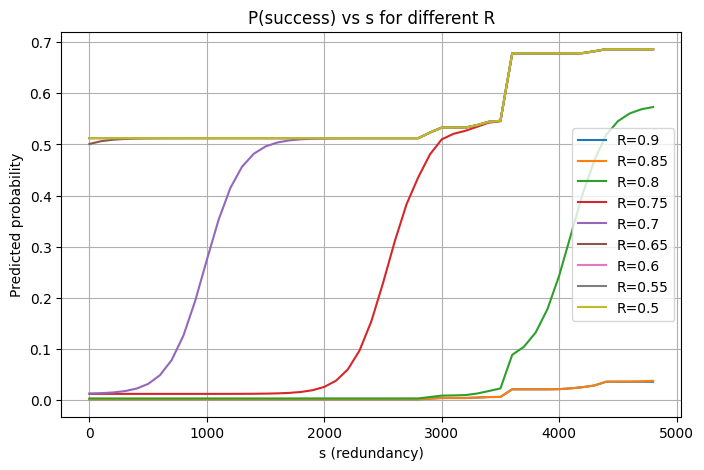

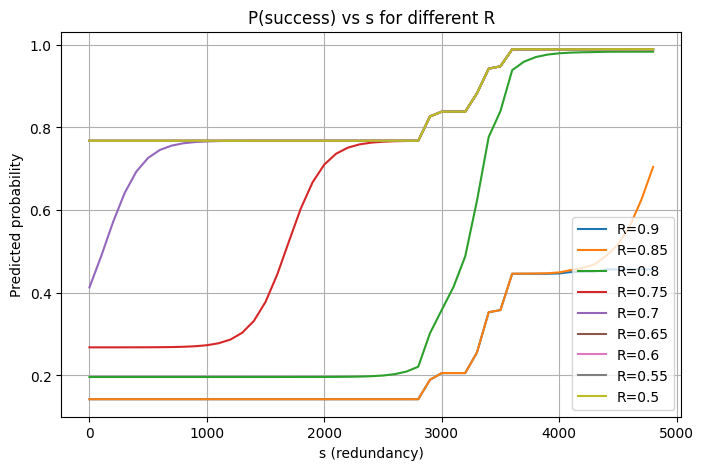

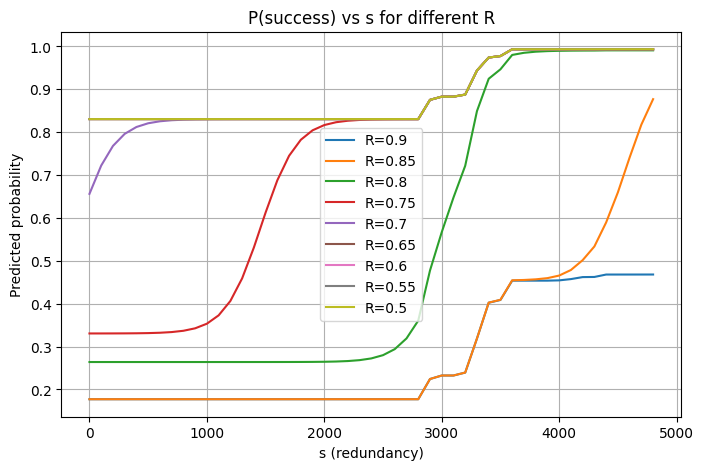

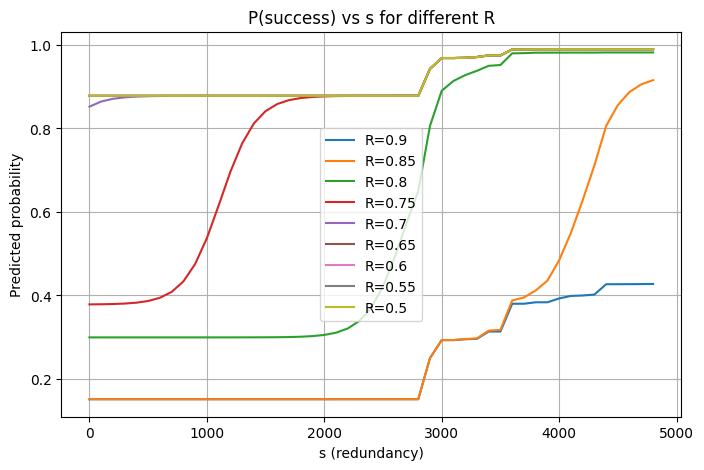

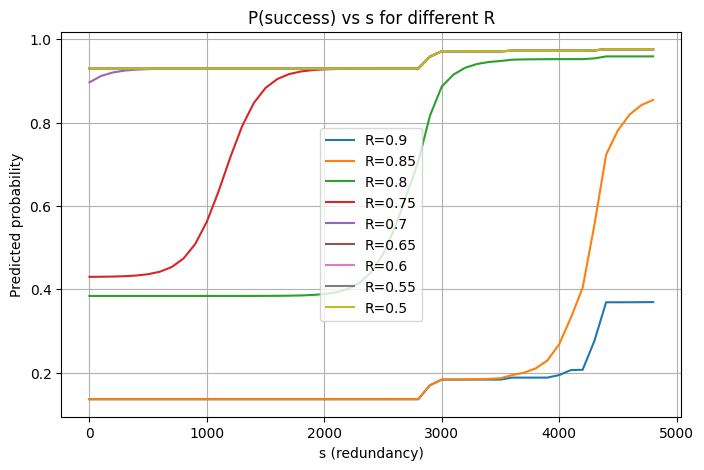

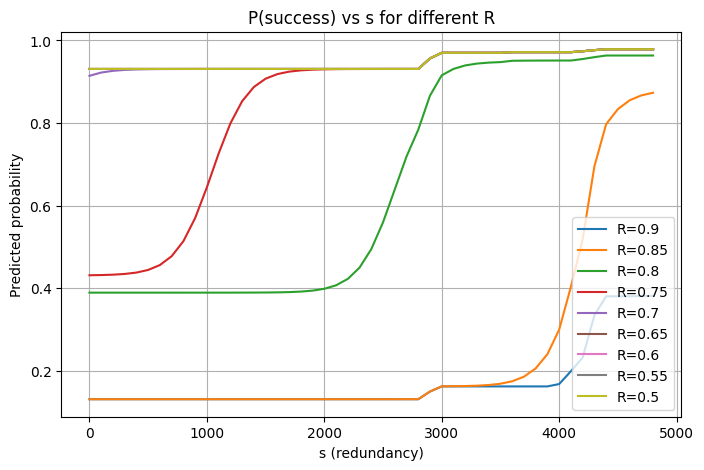

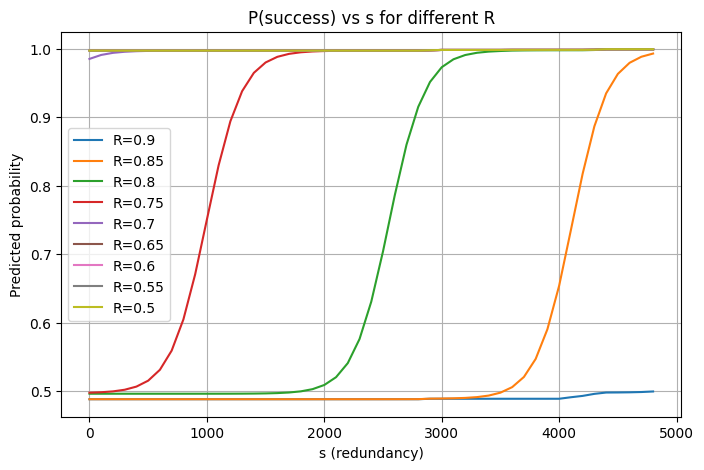

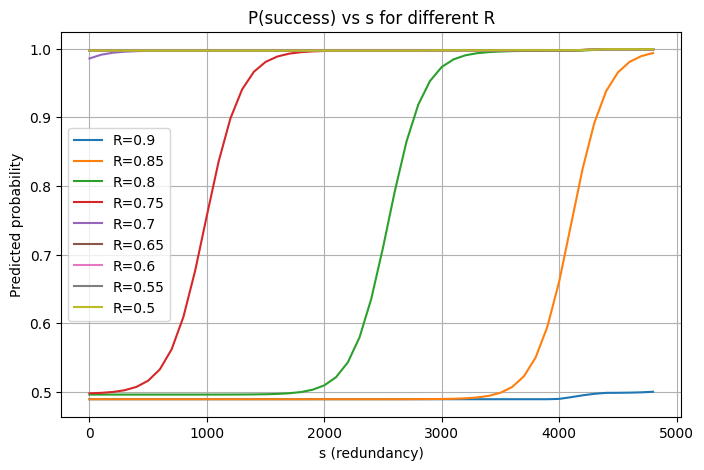

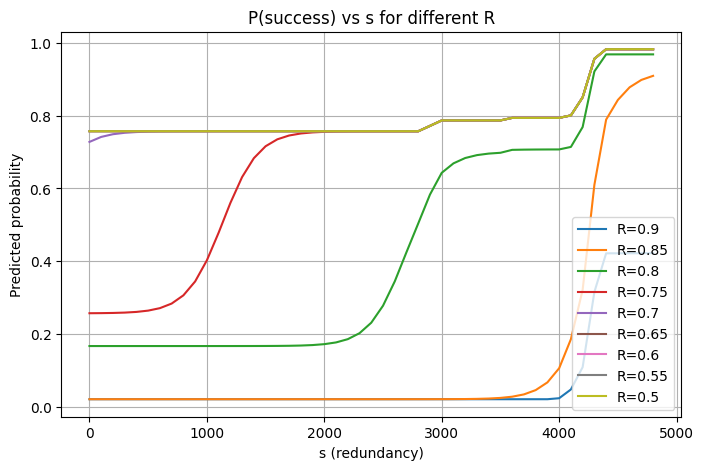

KeyboardInterrupt: 

In [ ]:
def plot_R_s_dependence(current_features, classifier, feature_names, sp_count=4800):
    R_values = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.50]
    s_values = np.arange(0, sp_count+1, 100)

    plt.figure(figsize=(8,5))
    for R in R_values:
        probs = []
        for s in s_values:
            fv = current_features.copy()
            fv['R'] = R
            fv['s'] = s
            probs_lgbm = lgbm.predict_proba([fv[feature_names].values])[0, 1]
            probs_logreg = log_reg.predict_proba([fv[feature_names].values])[0, 1]
            prob = 0.5 * probs_lgbm + 0.5 * probs_logreg
            probs.append(prob)
        plt.plot(s_values, probs, label=f"R={R}")

    plt.title("P(success) vs s for different R")
    plt.xlabel("s")
    plt.ylabel("Predicted probability")
    plt.legend()
    plt.grid(True)
    plt.show()
    
for i in range(100):
    sample_features = X_submission_clean.iloc[i]
    
    plot_R_s_dependence(sample_features, classifier, feature_names)